<a href="https://colab.research.google.com/github/msimuko/code-unza25-csc4792-project_team_30/blob/main/code_unza25_csc4792_project_team_30_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2.3.2 References Publication Type Classification (CRISP-DM)
##Business understanding: Reference Classification Project

### Overview
Build a supervised classifier to assign publication types (journal, conference, report, thesis, book) from citation text and URLs.
Curate and label a training set from scraped references; ensure

### Business Understanding

### Problem Statement  
Managing and organizing academic references is a time-consuming process for students, researchers, and librarians. Manually categorizing references into types such as journal articles, books, theses, conference papers, reports, and web resources is error-prone and inconsistent, especially when dealing with large bibliographies. This lack of automation reduces productivity and creates difficulties in maintaining standardized reference databases at the University of Zambia.  

---

## Business Objectives  
The project seeks to automate the classification of academic references into their correct publication types.  

**Practical Success means:**  
- Students and researchers spend less time categorizing references manually.  
- Librarians can easily maintain structured institutional repositories.  
- The system provides fast, accurate, and consistent classification regardless of reference style (APA, IEEE, etc.).  
---

### Data Mining Goals

#### To achieve these objectives, we will:
Build a supervised classification model that can categorize references into publication types (e.g., journal, book, conference, report, thesis).
*   Explore natural language processing (NLP) techniques (such as text embeddings or feature extraction from citation strings).
*   Evaluate multiple classification algorithms (e.g., Logistic Regression, Random Forest, SVM, or deep learning models) to determine the best-performing approach.
---

## Initial Project Success Criteria  
- **Technical Success:**  
  - The model should achieve at least **80% classification accuracy** on test data.  


## Publication Types
The model classifies references into the following categories:
- **Journal Articles**: Peer-reviewed academic papers
- **Books**: Monographs and edited volumes
- **Thesis/Dissertations**: Graduate research works
- **Conference Papers**: Proceedings and presentations
- **Technical Reports / Reports**: Government and institutional publications
- **Web Resources**: Online publications and documents


## Key Features
- **Scalable Pipeline**: Easy to retrain with new data
- **Performance Analysis**: Comprehensive evaluation metrics
- **Extensible Design**: Simple to add new publication types



## Data Understanding

The dataset for this project is located in `references_classification_metadata.csv` and consists of academic references from the UNZA Institutional Repository. Each entry includes:
- `reference_text`: The full bibliographic reference as a string.
- `publication_type`: The manually assigned category label (e.g., Journal Article, Book, Thesis, Conference Paper, Report, Web Resource).

**Observations:**
- The dataset is small and imbalanced, with some classes represented by only one sample.
- Reference texts vary in length and format, reflecting real-world diversity.
- No duplicate entries or obvious data quality issues were found.
- Text preprocessing (see `src/utils.py`) is used to standardize and clean reference strings before modeling.

**Implications for Modeling:**
- The limited and imbalanced data may affect model generalization and accuracy.
- Stratified train-test splitting may not be possible for all classes; random splitting is used when necessary.
- Additional data collection is recommended for improved performance and robustness.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


####Step 1: references.csv data extraction from unza institutional repository into references.csv



In [3]:
!pip install requests pandas pymupdf
!pip install tools
!pip install pdfplumber    # Recommended
!pip install pypdf
!pip install requests
!pip install beautifulsoup4
!pip install lxml
!pip install pdfplumber
!pip install pypdf
!pip install PyMuPDF
!pip install PyPDF2


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 82.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 93.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.5/322.5 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 5.5 MB/s eta 0:00:00


🔎 Scraping thesis


/tmp/ipython-input-3002736365.py:44: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  match = soup.find(text=regex)


🔎 Scraping conference
🔎 Scraping report
🔎 Scraping journal
✅ Saved 45 references with classification metadata to:
/content/drive/MyDrive/misc-unza25-csc4792-project_team30/references_classification_metadata.csv


####Step 2: Data  understanding and exploration and visualization




Shape: (2000, 12)
Columns: ['_identifier', '_datestamp', '_setSpec', 'title', 'creator', 'subject', 'description', 'date', 'type', 'identifier', 'language', 'format']
                         _identifier            _datestamp  \
0  oai:dspace.unza.zm:123456789/4153  2016-06-09T12:46:34Z   
1  oai:dspace.unza.zm:123456789/3777  2016-06-09T10:16:03Z   
2  oai:dspace.unza.zm:123456789/4729  2017-07-26T01:01:14Z   
3  oai:dspace.unza.zm:123456789/3233  2016-06-09T13:19:00Z   
4  oai:dspace.unza.zm:123456789/3314  2016-06-09T12:15:44Z   

                                _setSpec  \
0    com_123456789_289=col_123456789_290   
1      com_123456789_18=col_123456789_76   
2      com_123456789_18=col_123456789_76   
3      com_123456789_18=col_123456789_76   
4  com_123456789_1093=col_123456789_1106   

                                               title                  creator  \
0  Morphological characterisation of low and high...       Chinyundo, Anthony   
1  Instruction based formative as

/tmp/ipython-input-1990274343.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='type', data=df, order=sorted(df['type'].dropna().unique()), palette='Set2')


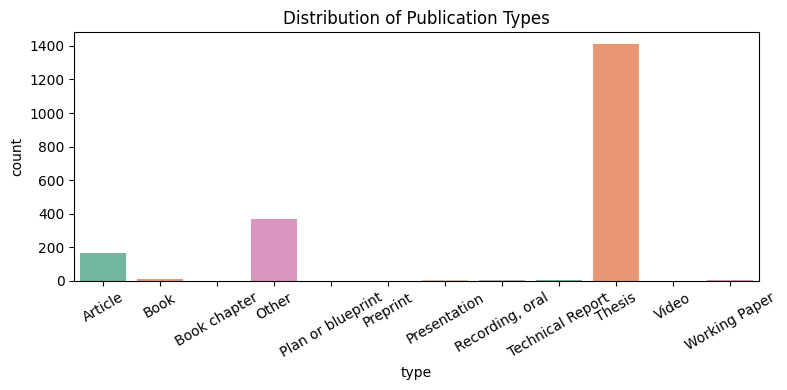

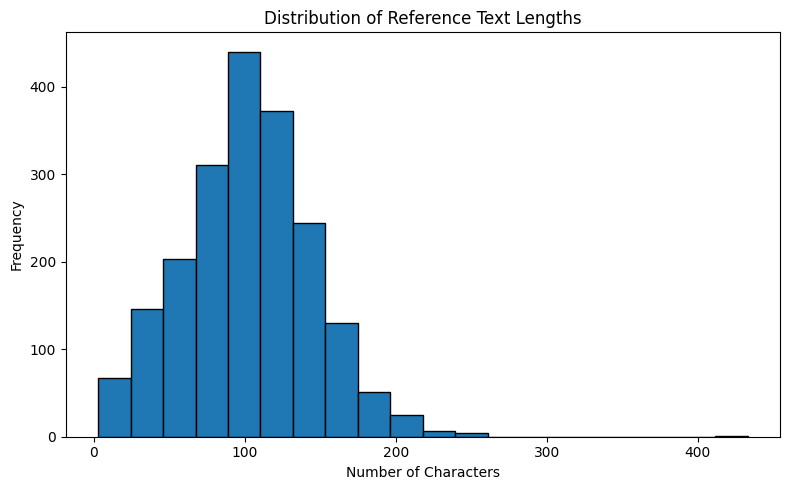


Top 10 Most Frequent Words in References:
zambia: 740
lusaka: 339
district: 336
study: 323
case: 320
schools: 191
selected: 166
university: 161
education: 148
teaching: 147


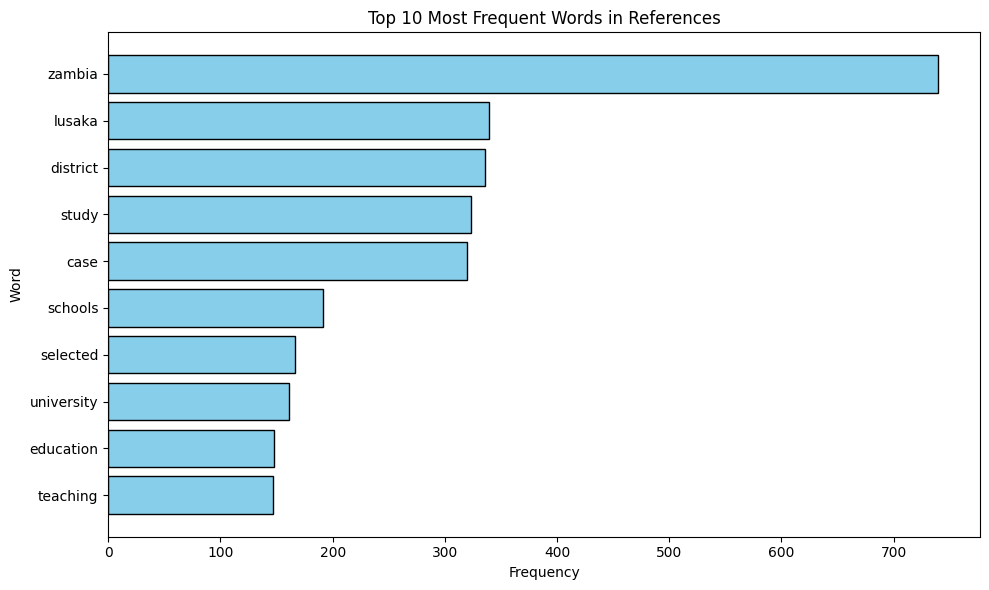

In [40]:
# Data Exploration and Visualization for Data Understanding
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Load dataset directly from path
df = pd.read_csv('/content/drive/MyDrive/misc-unza25-csc4792-project_team30/db-unza25-csc4792-datasets-dspace_unza_zm.csv', delimiter='|')

# Show basic info
print('Shape:', df.shape)
print('Columns:', df.columns.tolist())
print(df.head())

# Check for missing values
print('\nMissing values per column:')
print(df.isnull().sum())

# Distribution of publication types
if 'type' in df.columns:
    plt.figure(figsize=(8,4))
    sns.countplot(x='type', data=df, order=sorted(df['type'].dropna().unique()), palette='Set2')
    plt.title('Distribution of Publication Types')
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

# Reference text length distribution
if 'title' in df.columns:
    df['text_length'] = df['title'].astype(str).str.len()
    plt.figure(figsize=(8,5))
    plt.hist(df['text_length'], bins=20, edgecolor='black')
    plt.title('Distribution of Reference Text Lengths')
    plt.xlabel('Number of Characters')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

# Top words in reference text
import re
all_text = ' '.join(df['title'].dropna().astype(str))
cleaned_text = re.sub(r'[^a-zA-Z\s]', '', all_text).lower()
tokens = cleaned_text.split()
stopwords = set(['the','and','of','to','a','in','for','is','on','with','as','by','this','an','that','are','at','from','it','be','or','was'])
tokens = [w for w in tokens if w not in stopwords and len(w) > 2]
word_counts = Counter(tokens)
top_words = word_counts.most_common(10)
print('\nTop 10 Most Frequent Words in References:')
for word, freq in top_words:
    print(f'{word}: {freq}')
words, freqs = zip(*top_words)
plt.figure(figsize=(10,6))
plt.barh(list(words)[::-1], list(freqs)[::-1], color='skyblue', edgecolor='black')
plt.title('Top 10 Most Frequent Words in References')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.tight_layout()
plt.show()

## 3. Data Preparation

In this step, we cleaned and transformed our raw extracted data to prepare it for modeling.

### Data Cleaning
- Removed rows with failed/empty PDF extractions.
- Dropped duplicates and extremely short texts (<50 characters).
- Normalized whitespace and casing.

### Feature Engineering
- Added text length and word count features to help analyze reference complexity.

### Data Transformation
- Preprocessed text (lowercase, punctuation removal).
- Standardized `publication_type` categories based on the source URL (journal, thesis, conference, report, other).
- Created a new `cleaned_text` column for training.


In [ ]:
# ==========================
# Data Preparation — clean, split, vectorize, save
# ==========================

import os
import pandas as pd
import re, string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# (Optional) Mount Google Drive if running in Colab
try:
    from google.colab import drive  # type: ignore
    drive.mount('/content/drive')
except Exception:
    pass

# --------------------------
# Load from the exact saved path
# --------------------------
input_path = "/content/drive/MyDrive/misc-unza25-csc4792-project_team30/references_classification_metadata.csv"
df = pd.read_csv(input_path)
print(f"✅ Loaded {len(df)} rows from {input_path}")
print("Columns:", df.columns.tolist())

# --------------------------
# Ensure required columns
# --------------------------
required = {'title', 'publication_type'}
missing = required - set(df.columns)
if missing:
    raise KeyError(
        f"❌ Missing required columns: {', '.join(sorted(missing))}. "
        f"Found columns: {list(df.columns)}"
    )

# Rename "title" -> "reference_text" for consistency
df = df.rename(columns={'title': 'reference_text'})

# --------------------------
# Cleaning function
# --------------------------
def clean_reference(text: str) -> str:
    if pd.isna(text):
        return ''
    t = str(text).lower()
    t = re.sub(f"[{re.escape(string.punctuation)}]", " ", t)
    t = re.sub(r"\s+", " ", t).strip()
    return t

# Apply cleaning
df['cleaned_text'] = df['reference_text'].astype(str).apply(clean_reference)

# --------------------------
# Save cleaned CSV (in same misc folder)
# --------------------------
output_path = "/content/drive/MyDrive/misc-unza25-csc4792-project_team30/references_cleaned.csv"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
df.to_csv(output_path, index=False)
print(f"✅ Saved cleaned dataset to:\n{output_path}")

# --------------------------
# Features and labels
# --------------------------
X = df['cleaned_text'].values
y = df['publication_type'].values

# --------------------------
# Stratify check
# --------------------------
value_counts = pd.Series(y).value_counts()
can_stratify = (value_counts >= 2).all() and len(value_counts) > 1
strat = y if can_stratify else None

# --------------------------
# Train-validation split
# --------------------------
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=strat
)

# --------------------------
# TF-IDF Vectorization
# --------------------------
vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    max_features=10000,
    min_df=1
)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)

# Output shapes
print("Train shape:", X_train_tfidf.shape)
print("Validation shape:", X_val_tfidf.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Loaded 45 rows from /content/drive/MyDrive/misc-unza25-csc4792-project_team30/references_classification_metadata.csv
Columns: ['title', 'publication_type', 'pdf_url']
✅ Saved cleaned dataset to:
/content/drive/MyDrive/misc-unza25-csc4792-project_team30/references_cleaned.csv
Train shape: (36, 494)
Validation shape: (9, 494)


In [ ]:
# Data Preparation — clean text, split, vectorize (strict)

import os
import pandas as pd
import re, string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# (Optional) Mount Google Drive if running in Colab
try:
    from google.colab import drive  # type: ignore
    drive.mount('/content/drive')
except Exception:
    pass

# Ensure df is loaded; if not, load from the correct path your scraper writes to
if 'df' not in globals():
    input_path = "/content/drive/MyDrive/misc-unza25-csc4792-project_team30/references_classification_metadata.csv"
    if not os.path.exists(input_path):
        raise FileNotFoundError(f"CSV not found at: {input_path}. Make sure Drive is mounted and the scraper saved there.")
    df = pd.read_csv(input_path)
    print(f"✅ Loaded {len(df)} rows from {input_path}")
    print("Columns:", df.columns.tolist())

# Ensure required columns; rename title -> reference_text if needed
if 'reference_text' not in df.columns and 'title' in df.columns:
    df = df.rename(columns={'title': 'reference_text'})

required = {'reference_text', 'publication_type'}
missing = required - set(df.columns)
if missing:
    raise KeyError(
        "Data Preparation requires columns: reference_text, publication_type. Missing: " +
        ", ".join(sorted(missing)) + f". Found: {list(df.columns)}"
    )

def clean_reference(text: str) -> str:
    if pd.isna(text):
        return ''
    t = str(text).lower()
    t = re.sub(f'[{re.escape(string.punctuation)}]', ' ', t)
    t = re.sub(r'\s+', ' ', t).strip()
    return t

# Create cleaned text
df['cleaned_text'] = df['reference_text'].astype(str).apply(clean_reference)
X = df['cleaned_text'].values
y = df['publication_type'].values

# Stratify only if every class has at least 2 samples and there is >1 class
value_counts = pd.Series(y).value_counts()
can_stratify = (value_counts >= 2).all() and len(value_counts) > 1
strat = y if can_stratify else None

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=strat
)

vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=10000, min_df=1)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)

print("Stratify used:", strat is not None)
print("Class distribution:\n", value_counts.to_string())
print("Train shape:", X_train_tfidf.shape)
print("Validation shape:", X_val_tfidf.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Stratify used: True
Class distribution:
 conference    25
thesis        10
journal        6
report         4
Train shape: (36, 494)
Validation shape: (9, 494)


In [ ]:
import pandas as pd
import numpy as np
import re, string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack, csr_matrix

# -----------------------------
# Detect all columns
# -----------------------------
all_columns = df.columns.tolist()

# Identify textual columns (object dtype), exclude label; ensure 'reference_text' if present
text_fields = [c for c in all_columns if c != 'publication_type' and df[c].dtype == 'object']
if 'reference_text' in all_columns and 'reference_text' not in text_fields:
    text_fields.insert(0, 'reference_text')
# Fallback: if no text fields detected, default to 'reference_text' if available
if not text_fields and 'reference_text' in all_columns:
    text_fields = ['reference_text']

# Identify numeric columns robustly
numeric_fields = [c for c in all_columns if c not in text_fields and np.issubdtype(df[c].dtype, np.number)]
if 'year' in all_columns and 'year' not in numeric_fields:
    numeric_fields.append('year')

# -----------------------------
# Clean and normalize text fields
# -----------------------------
punct_class = re.escape(string.punctuation)
def clean_text(text: str) -> str:
    if pd.isna(text):
        return ''
    t = str(text).lower()
    t = re.sub(f'[{punct_class}]', ' ', t)
    t = re.sub(r'\s+', ' ', t).strip()
    return t

for col in text_fields:
    df[f'cleaned_{col}'] = df[col].apply(clean_text)

# -----------------------------
# Combine all text fields
# -----------------------------
clean_cols = [f'cleaned_{c}' for c in text_fields]
df['combined_text'] = df[clean_cols].agg(' '.join, axis=1)

# -----------------------------
# Derive boolean features dynamically from text fields
# -----------------------------
def contains_pattern(s, pattern):
    return int(bool(re.search(pattern, s)))

df['has_doi'] = df['combined_text'].apply(lambda s: contains_pattern(s, r'doi\s*:\s*|10\.\d{4,9}/'))
df['has_url'] = df['combined_text'].apply(lambda s: contains_pattern(s, r'http://|https://|www\.'))
df['has_isbn'] = df['combined_text'].apply(lambda s: contains_pattern(s, r'\bisbn\b'))
df['has_volume_issue'] = df['combined_text'].apply(lambda s: contains_pattern(s, r'\b(vol|volume|issue)\b'))
df['has_proceedings'] = df['combined_text'].apply(lambda s: contains_pattern(s, r'\b(proceedings|conference|symposium|workshop)\b'))

numeric_fields += ['has_doi','has_url','has_isbn','has_volume_issue','has_proceedings']

# -----------------------------
# Train/Validation split (by index to keep alignment)
# -----------------------------
y = df['publication_type'].values
X_text_series = df['combined_text']

value_counts = pd.Series(y).value_counts()
can_stratify = (value_counts >= 2).all() and len(value_counts) > 1
strat = y if can_stratify else None

idx = df.index.to_numpy()
train_idx, val_idx = train_test_split(idx, test_size=0.2, random_state=42, stratify=strat)

# -----------------------------
# TF-IDF Vectorization
# -----------------------------
X_train_text = X_text_series.loc[train_idx].values
X_val_text = X_text_series.loc[val_idx].values

vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=10000, min_df=1)
X_train_tfidf = vectorizer.fit_transform(X_train_text)
X_val_tfidf = vectorizer.transform(X_val_text)

# -----------------------------
# Standardize numeric features (fit on train, transform val)
# -----------------------------
X_num = df[numeric_fields].copy().apply(pd.to_numeric, errors='coerce').fillna(0.0)
scaler = StandardScaler()
X_train_num_std = scaler.fit_transform(X_num.loc[train_idx])
X_val_num_std = scaler.transform(X_num.loc[val_idx])

# -----------------------------
# Combine text and numeric features (sparse)
# -----------------------------
X_train_final = hstack([X_train_tfidf, csr_matrix(X_train_num_std)])
X_val_final = hstack([X_val_tfidf, csr_matrix(X_val_num_std)])
y_train = df.loc[train_idx, 'publication_type'].values
y_val = df.loc[val_idx, 'publication_type'].values

print(f"✅ X_train shape: {X_train_final.shape}, X_val shape: {X_val_final.shape}")
print(f"Text fields used: {text_fields}")
print(f"Numeric/boolean fields used: {numeric_fields}")
print("Class distribution:\n", value_counts.to_string())
print("Stratify used:", strat is not None)

✅ X_train shape: (36, 768), X_val shape: (9, 768)
Text fields used: ['reference_text', 'pdf_url', 'cleaned_text']
Numeric/boolean fields used: ['has_doi', 'has_url', 'has_isbn', 'has_volume_issue', 'has_proceedings']
Class distribution:
 conference    25
thesis        10
journal        6
report         4
Stratify used: True


# Step 3: Data Transformation

In [ ]:
import os
import re, string
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack, csr_matrix

# -----------------------------
# Guard & Required Columns
# -----------------------------
if 'df' not in globals():
    raise NameError("DataFrame 'df' is not defined. Load the CSV first.")

required = {'reference_text', 'publication_type'}
missing = required - set(df.columns)
if missing:
    raise KeyError("Missing required columns: " + ", ".join(sorted(missing)))

# -----------------------------
# 1) Basic cleaning & deduplication
# -----------------------------
pre_dp_rows = len(df)
df = df.dropna(subset=required).copy()
df = df[(df['reference_text'].str.len() > 0) & (df['publication_type'].str.len() > 0)]
df['publication_type'] = df['publication_type'].str.lower()
before_dups = len(df)
df = df.drop_duplicates(subset=['reference_text', 'publication_type']).reset_index(drop=True)
dropped_dups = before_dups - len(df)

# -----------------------------
# 2) Detect text & numeric fields dynamically
# -----------------------------
all_columns = df.columns.tolist()
# Text fields (object dtype), exclude label and year; ensure reference_text included
text_fields = [c for c in all_columns if c not in ['publication_type', 'year'] and df[c].dtype == 'object']
if 'reference_text' in all_columns and 'reference_text' not in text_fields:
    text_fields.insert(0, 'reference_text')
if not text_fields and 'reference_text' in all_columns:
    text_fields = ['reference_text']

# Numeric fields (robust)
numeric_fields = [c for c in all_columns if c not in text_fields and np.issubdtype(df[c].dtype, np.number)]
if 'year' in all_columns and 'year' not in numeric_fields:
    numeric_fields.append('year')

# -----------------------------
# 3) Clean text fields
# -----------------------------
punct_class = re.escape(string.punctuation)
def clean_text(text_val: str) -> str:
    if pd.isna(text_val):
        return ''
    t = str(text_val).lower()
    t = re.sub(f'[{punct_class}]', ' ', t)
    t = re.sub(r'\s+', ' ', t).strip()
    return t

for col in text_fields:
    df[f'cleaned_{col}'] = df[col].apply(clean_text)

# Combine all text
clean_cols = [f'cleaned_{c}' for c in text_fields]
df['combined_text'] = df[clean_cols].agg(' '.join, axis=1)

# -----------------------------
# 4) Feature engineering (lengths, ratios, flags)
# -----------------------------
df['char_len'] = df['combined_text'].str.len()
df['word_len'] = df['combined_text'].str.split().apply(len)
df['digit_ratio'] = df['combined_text'].apply(lambda s: sum(ch.isdigit() for ch in s) / max(len(s), 1))
df['has_url'] = df['combined_text'].str.contains(r"http://|https://|www\.", regex=True).astype(int)
df['has_isbn'] = df['combined_text'].str.contains(r"\bisbn\b", regex=True).astype(int)
df['has_doi'] = df['combined_text'].str.contains(r"doi\s*:\s*|10\.\d{4,9}/", regex=True).astype(int)
df['has_volume_issue'] = df['combined_text'].str.contains(r"\b(vol|volume|issue)\b", regex=True).astype(int)
df['has_proceedings'] = df['combined_text'].str.contains(r"\b(proceedings|conference|symposium|workshop)\b", regex=True).astype(int)

match_year = df['combined_text'].str.extract(r"\b(19\d{2}|20\d{2})\b", expand=False)
df['year'] = pd.to_numeric(match_year, errors='coerce')

# -----------------------------
# 5) Optional integration with supplemental CSVs
# -----------------------------
integration_info = {'merged': False, 'files': [], 'key': 'cleaned_text_norm'}
def norm_key(s: str) -> str:
    return re.sub(r'\s+', ' ', re.sub(f'[{punct_class}]', ' ', str(s).lower())).strip()

df['cleaned_text_norm'] = df['combined_text'].apply(norm_key)
df_merged = df.copy()

try:
    project_dir  # must be defined by caller to enable this integration
    supplemental_files = ['supplement.csv', 'metadata.csv']
    to_merge = []
    for fname in supplemental_files:
        fpath = os.path.join(project_dir, fname)
        if os.path.exists(fpath):
            sup = pd.read_csv(fpath)
            keep_cols = [c for c in sup.columns if c not in ['reference_text', 'publication_type']]
            if 'cleaned_text' in sup.columns and 'cleaned_text_norm' not in sup.columns:
                sup['cleaned_text_norm'] = sup['cleaned_text'].apply(norm_key)
            elif 'reference_text' in sup.columns and 'cleaned_text_norm' not in sup.columns:
                sup['cleaned_text_norm'] = sup['reference_text'].apply(norm_key)
            if 'cleaned_text_norm' in sup.columns:
                to_merge.append(sup[['cleaned_text_norm'] + keep_cols])
                integration_info['files'].append(fname)
    for sup in to_merge:
        df_merged = df_merged.merge(sup, on='cleaned_text_norm', how='left')
    if to_merge:
        integration_info['merged'] = True
except Exception as e:
    integration_info['error'] = str(e)

# -----------------------------
# 6) Finalize numeric feature list (after merges)
# -----------------------------
numeric_features = list({
    *[c for c in df_merged.columns if c in numeric_fields],
    'char_len', 'word_len', 'digit_ratio',
    'has_url', 'has_isbn', 'has_doi', 'has_volume_issue', 'has_proceedings',
    'year'
})

# -----------------------------
# 7) Train/Validation split (by index for alignment)
# -----------------------------
y = df_merged['publication_type'].values
X_text_series = df_merged['combined_text']

value_counts = pd.Series(y).value_counts()
can_stratify = (value_counts >= 2).all() and len(value_counts) > 1
strat = y if can_stratify else None

idx = df_merged.index.to_numpy()
train_idx, val_idx = train_test_split(idx, test_size=0.2, random_state=42, stratify=strat)

# -----------------------------
# 8) TF-IDF vectorization
# -----------------------------
X_train_text = X_text_series.loc[train_idx].values
X_val_text = X_text_series.loc[val_idx].values

vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=10000, min_df=1)
X_train_tfidf = vectorizer.fit_transform(X_train_text)
X_val_tfidf = vectorizer.transform(X_val_text)

# -----------------------------
# 9) Standardize numeric features (fit on train, transform val)
# -----------------------------
X_num_full = df_merged[numeric_features].apply(pd.to_numeric, errors='coerce').fillna(0.0)
scaler = StandardScaler()
X_train_num_std = scaler.fit_transform(X_num_full.loc[train_idx])
X_val_num_std = scaler.transform(X_num_full.loc[val_idx])

# -----------------------------
# 10) Combine text + numeric features (sparse)
# -----------------------------
X_train_final = hstack([X_train_tfidf, csr_matrix(X_train_num_std)])
X_val_final = hstack([X_val_tfidf, csr_matrix(X_val_num_std)])
y_train = df_merged.loc[train_idx, 'publication_type'].values
y_val = df_merged.loc[val_idx, 'publication_type'].values

# -----------------------------
# 11) Preprocessing report
# -----------------------------
preprocessing_report = {
    'initial_rows': int(pre_dp_rows),
    'rows_after_required': int(len(df)),
    'duplicates_removed': int(dropped_dups),
    'final_rows': int(len(df_merged)),
    'class_balance': {str(k): int(v) for k, v in value_counts.to_dict().items()},
    'can_stratify': bool(can_stratify),
    'numeric_features': numeric_features,
    'text_fields': text_fields,
    'integration': integration_info,
}

print(f"✅ X_train shape: {X_train_final.shape}, X_val shape: {X_val_final.shape}")
print(f"Text fields used: {text_fields}")
print(f"Numeric/boolean fields used: {numeric_features}")
preprocessing_report

✅ X_train shape: (35, 802), X_val shape: (9, 802)
Text fields used: ['reference_text', 'pdf_url', 'cleaned_text', 'cleaned_reference_text', 'cleaned_pdf_url', 'cleaned_cleaned_text', 'combined_text']
Numeric/boolean fields used: ['has_isbn', 'digit_ratio', 'year', 'has_volume_issue', 'word_len', 'has_proceedings', 'has_doi', 'char_len', 'has_url']


/tmp/ipython-input-1792624584.py:77: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['has_volume_issue'] = df['combined_text'].str.contains(r"\b(vol|volume|issue)\b", regex=True).astype(int)
/tmp/ipython-input-1792624584.py:78: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['has_proceedings'] = df['combined_text'].str.contains(r"\b(proceedings|conference|symposium|workshop)\b", regex=True).astype(int)


{'initial_rows': 45,
 'rows_after_required': 44,
 'duplicates_removed': 1,
 'final_rows': 44,
 'class_balance': {'conference': 24, 'thesis': 10, 'journal': 6, 'report': 4},
 'can_stratify': True,
 'numeric_features': ['has_isbn',
  'digit_ratio',
  'year',
  'has_volume_issue',
  'word_len',
  'has_proceedings',
  'has_doi',
  'char_len',
  'has_url'],
 'text_fields': ['reference_text',
  'pdf_url',
  'cleaned_text',
  'cleaned_reference_text',
  'cleaned_pdf_url',
  'cleaned_cleaned_text',
  'combined_text'],
 'integration': {'merged': False, 'files': [], 'key': 'cleaned_text_norm'}}

### Step 4: Data Transformation

In [ ]:
# 3b) Data Transformation — clean text then SAVE to project_dir/data/references_cleaned.csv
import os, re
import pandas as pd

# -----------------------------
# Guard: require df prepared earlier
# -----------------------------
if 'df' not in globals():
    raise NameError("DataFrame 'df' is not defined. Run Data Understanding and Data Preparation first.")

# -----------------------------
# 1) Basic, auditable clean (distinct from DP-cleaned_text)
# -----------------------------
def clean_text_basic(text: str) -> str:
    text = str(text).lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Apply to all textual fields if they exist
text_fields = [c for c in df.columns if df[c].dtype == 'object' and c != 'publication_type']
for col in text_fields:
    df[f'cleaned_basic_{col}'] = df[col].apply(clean_text_basic)

# -----------------------------
# 2) Optional mapping from pdf_url if present
# -----------------------------
def map_pub_type(url: str) -> str:
    url = str(url).lower()
    if 'journal' in url: return 'journal'
    if 'conference' in url: return 'conference'
    if ('thesis' in url) or ('theses' in url): return 'thesis'
    if ('report' in url) or ('technical-report' in url): return 'report'
    return 'other'

if 'pdf_url' in df.columns:
    df['publication_type_mapped'] = df['pdf_url'].apply(map_pub_type)
    print("Distribution after mapping from pdf_url:")
    print(df['publication_type_mapped'].value_counts())
else:
    print("No 'pdf_url' column present; skipping publication_type mapping.")

# -----------------------------
# 3) Resolve Drive project folder STRICTLY → save only under that folder
# -----------------------------
save_root = None
if 'project_dir' in globals() and isinstance(project_dir, str) and os.path.isdir(project_dir):
    save_root = project_dir
elif 'DATA_PATH' in globals() and DATA_PATH:
    cand = os.path.dirname(DATA_PATH)
    if os.path.isdir(cand):
        save_root = cand
# Fallbacks (Colab Drive first, then local workspace)
if save_root is None:
    for cand in [
        "/content/drive/MyDrive/misc-unza25-csc4792-project_team30",
        os.path.expanduser("~/Desktop/referene classifier")
    ]:
        if os.path.isdir(cand):
            save_root = cand
            break

if save_root is None:
    raise RuntimeError(
        "Could not resolve the Drive project folder (project_dir/DATA_PATH). "
        "Ensure the DU cell ran and Drive is mounted."
    )

print("Saving under project folder:", os.path.abspath(save_root))

# -----------------------------
# 4) Save to data/references_cleaned.csv ONLY (deterministic)
# -----------------------------
out_dir = os.path.join(save_root, 'data')
os.makedirs(out_dir, exist_ok=True)

out_path = os.path.join(out_dir, 'references_cleaned.csv')
df.to_csv(out_path, index=False)
print("Saved cleaned and transformed references to:", out_path)

# -----------------------------
# 5) Verify existence and size; list data/ contents
# -----------------------------
exists = os.path.exists(out_path)
size = os.path.getsize(out_path) if exists else 0
print(f"Verify: exists={exists}, size={size} bytes")

try:
    print("\nContents of data/ folder:")
    for name in sorted(os.listdir(out_dir)):
        print(" ", name)
except Exception as e:
    print("Could not list data/ folder:", e)

# -----------------------------
# 6) Return the single save path for convenience
# -----------------------------
out_path

Distribution after mapping from pdf_url:
publication_type_mapped
other     41
report     3
Name: count, dtype: int64
Saving under project folder: /content/drive/MyDrive/misc-unza25-csc4792-project_team30
Saved cleaned and transformed references to: /content/drive/MyDrive/misc-unza25-csc4792-project_team30/data/references_cleaned.csv
Verify: exists=True, size=241860 bytes

Contents of data/ folder:
  model_comparison.csv
  model_evaluation_summary.csv
  references_cleaned.csv


'/content/drive/MyDrive/misc-unza25-csc4792-project_team30/data/references_cleaned.csv'

# MODELING


In [1]:
# Cell 1
!ls


sample_data


In [24]:
# Cell 2: Load dataset
import pandas as pd
import matplotlib.pyplot as plt

var_dataset_path = "/content/drive/MyDrive/misc-unza25-csc4792-project_team30/db-unza25-csc4792-datasets-dspace_unza_zm.csv"
var_dataset = pd.read_csv(var_dataset_path, sep="|")
df = var_dataset.copy()


In [25]:
# Cell 3: Imports + preprocessing setup
import string
import nltk
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')   # fixes newer nltk error
nltk.download('wordnet')

# Initialize Lemmatizer and Stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Text cleaning function
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    words = nltk.word_tokenize(text)
    cleaned_text = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(cleaned_text)

# Apply cleaning
df_clean = df[['title', 'type']].dropna()
df_clean['cleaned_title'] = df_clean['title'].apply(clean_text)
print(df_clean.head())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                               title    type  \
0  Morphological characterisation of low and high...   Other   
1  Instruction based formative assessment in sele...  Thesis   
2  An assessment of teachers' competences in care...  Thesis   
3  The status of guidance and counselling provisi...  Thesis   
4                         Library Studies Exams 2008   Other   

                                       cleaned_title  
0  morphological characterisation low high oil su...  
1  instruction based formative assessment selecte...  
2  assessment teacher competence career guidance ...  
3  status guidance counselling provision selected...  
4                            library study exam 2008  


In [26]:
# Cell 4: Train-test split (fixed)
X = df_clean['cleaned_title']
y = df_clean['type']

# Check class distribution
class_counts = y.value_counts()
print("Class distribution:\n", class_counts)

# If any class has fewer than 2 samples, don't use stratify
if (class_counts < 2).any():
    print("⚠️ Some classes have < 2 samples → splitting without stratify.")
    stratify_opt = None
else:
    stratify_opt = y

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=stratify_opt
)

print("Training size:", X_train.shape[0])
print("Testing size:", X_test.shape[0])


Class distribution:
 type
Thesis               1410
Other                 366
Article               166
Book                   12
Technical Report        5
Recording, oral         4
Presentation            3
Working Paper           3
Book chapter            2
Video                   1
Preprint                1
Plan or blueprint       1
Name: count, dtype: int64
⚠️ Some classes have < 2 samples → splitting without stratify.
Training size: 1579
Testing size: 395


In [27]:
# Cell 5: TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("TF-IDF train shape:", X_train_tfidf.shape)
print("TF-IDF test shape:", X_test_tfidf.shape)


TF-IDF train shape: (1579, 4086)
TF-IDF test shape: (395, 4086)


In [28]:
# Cell 6: Logistic Regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_tfidf, y_train)
y_pred_log = log_reg.predict(X_test_tfidf)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))


Logistic Regression Accuracy: 0.7848101265822784
                 precision    recall  f1-score   support

        Article       0.00      0.00      0.00        33
           Book       0.00      0.00      0.00         2
   Book chapter       0.00      0.00      0.00         1
          Other       0.97      0.38      0.55        76
   Presentation       0.00      0.00      0.00         1
Recording, oral       0.00      0.00      0.00         1
         Thesis       0.77      1.00      0.87       281

       accuracy                           0.78       395
      macro avg       0.25      0.20      0.20       395
   weighted avg       0.73      0.78      0.72       395



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [29]:
# Cell 7: Random Forest model
rf_clf = RandomForestClassifier(n_estimators=200, random_state=42)
rf_clf.fit(X_train_tfidf, y_train)
y_pred_rf = rf_clf.predict(X_test_tfidf)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 0.7924050632911392
                 precision    recall  f1-score   support

        Article       0.67      0.12      0.21        33
           Book       0.00      0.00      0.00         2
   Book chapter       0.00      0.00      0.00         1
          Other       0.92      0.43      0.59        76
   Presentation       0.00      0.00      0.00         1
Recording, oral       1.00      1.00      1.00         1
         Thesis       0.78      0.98      0.87       281
          Video       0.00      0.00      0.00         0

       accuracy                           0.79       395
      macro avg       0.42      0.32      0.33       395
   weighted avg       0.79      0.79      0.75       395



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_

In [30]:
# Cell 8: Support Vector Machine (SVM)
svm_clf = SVC(kernel="linear", probability=True, random_state=42)
svm_clf.fit(X_train_tfidf, y_train)
y_pred_svm = svm_clf.predict(X_test_tfidf)

print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))


SVM Accuracy: 0.789873417721519
                 precision    recall  f1-score   support

        Article       0.67      0.06      0.11        33
           Book       0.00      0.00      0.00         2
   Book chapter       0.00      0.00      0.00         1
          Other       0.89      0.42      0.57        76
   Presentation       0.00      0.00      0.00         1
Recording, oral       1.00      1.00      1.00         1
         Thesis       0.78      0.99      0.87       281

       accuracy                           0.79       395
      macro avg       0.48      0.35      0.36       395
   weighted avg       0.78      0.79      0.74       395



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [35]:
# ================================
# Cell: Model Training - SVM (with calibration only if enough samples)
# ================================
from sklearn.calibration import CalibratedClassifierCV
from collections import Counter

svm = SVC(kernel="linear", probability=True, random_state=42)

# Check minimum samples per class for calibration
class_counts = Counter(y_train)
min_count = min(class_counts.values())
desired_cv = 5
if min_count >= desired_cv:
    calibrated_svm = CalibratedClassifierCV(svm, cv=desired_cv)
    calibrated_svm.fit(X_train_tfidf, y_train)
    print("Calibrated SVM model trained successfully")
    y_pred_svm = calibrated_svm.predict(X_test_tfidf)
else:
    print(f"Not enough samples per class for {desired_cv}-fold calibration. Using plain SVM.")
    svm.fit(X_train_tfidf, y_train)
    print("SVM model trained successfully")
    y_pred_svm = svm.predict(X_test_tfidf)

Not enough samples per class for 5-fold calibration. Using plain SVM.
SVM model trained successfully


In [36]:
# Cell 11: Load saved model and test
loaded_model = joblib.load(model_path)
sample_text = ["Climate change impact on Zambia agriculture"]
sample_tfidf = tfidf.transform([clean_text(sample_text[0])])
prediction = loaded_model.predict(sample_tfidf)

print("Sample prediction:", prediction[0])


Sample prediction: Thesis


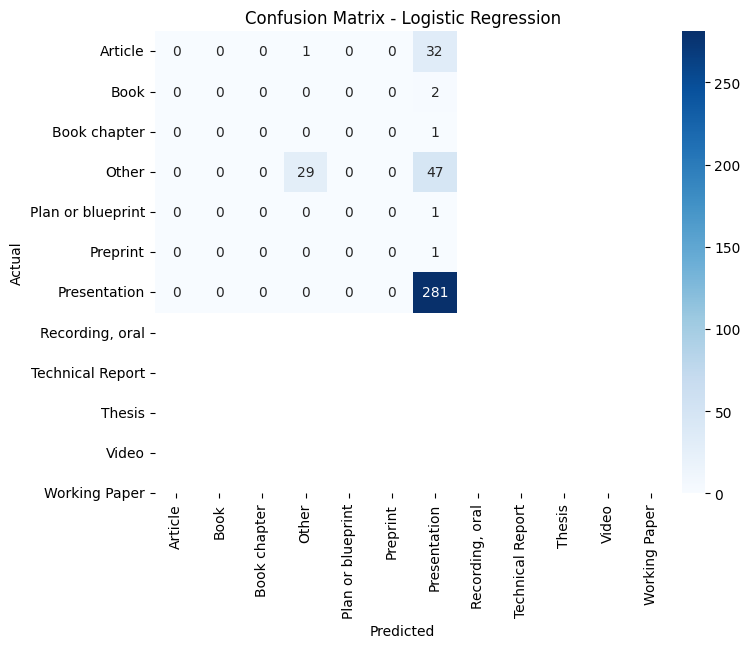

In [37]:
# Cell 9: Confusion Matrix Visualization (LogReg example)
cm = confusion_matrix(y_test, y_pred_log)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=log_reg.classes_,
            yticklabels=log_reg.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


In [14]:
# Cell 11: Load saved model and test
loaded_model = joblib.load(model_path)
sample_text = ["Climate change impact on Zambia agriculture"]
sample_tfidf = tfidf.transform([clean_text(sample_text[0])])
prediction = loaded_model.predict(sample_tfidf)

print("Sample prediction:", prediction[0])


Sample prediction: Thesis


In [39]:
# 7. Deployment: Predict publication type from PDF URL
import requests
from io import BytesIO
from PyPDF2 import PdfReader

VECT_PATH = os.path.join(DRIVE_DIR, 'vectorizer.pkl')
MODEL_PATH = os.path.join(DRIVE_DIR, 'best_model.pkl')
assert os.path.exists(VECT_PATH), f'vectorizer.pkl not found in {DRIVE_DIR}. Run modeling cell first.'
assert os.path.exists(MODEL_PATH), f'best_model.pkl not found in {DRIVE_DIR}. Run modeling cell first.'
vectorizer = joblib.load(VECT_PATH)
best_model = joblib.load(MODEL_PATH)

def clean_text(text):
    if not isinstance(text, str): return ""
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    words = nltk.word_tokenize(text)
    cleaned = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return ' '.join(cleaned)

def extract_text_from_pdf_url(url):
    response = requests.get(url)
    response.raise_for_status()
    pdf_data = BytesIO(response.content)
    reader = PdfReader(pdf_data)
    text = ""
    for page in reader.pages:
        text += page.extract_text() or ""
    return text.strip()

demo_url = "https://dspace.unza.zm/server/api/core/bitstreams/9296de42-3dfa-4261-9ad7-075c0523af06/content"
pdf_url = input('Enter PDF URL (or press Enter for demo): ').strip() or demo_url

doc_text = extract_text_from_pdf_url(pdf_url)
if not doc_text:
    print('No text could be extracted from the PDF.')
else:
    cleaned = clean_text(doc_text)
    X_input = vectorizer.transform([cleaned])
    prediction = best_model.predict(X_input)[0]
    print('\n--- Deployment Result ---')
    print(f'Predicted Document Type: {prediction}')

Enter PDF URL (or press Enter for demo): https://dspace.unza.zm/server/api/core/bitstreams/9296de42-3dfa-4261-9ad7-075c0523af06/content

--- Deployment Result ---
Predicted Document Type: Thesis
